# Chapter 4 - Policy Gradient Methods

This notebook implements a REINFORCE algorithm. The policy network accepts
state vectors as inputs and produces a (discrete) probability distribution over the possible actions.

The code and theory is based on Alexander Zai. “Deep Reinforcement Learning in Action MEAP V06”. Apple Books. 

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [3]:
env = gym.make("CartPole-v0")

/Users/jluissamper/.virtualenvs/pytorch/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


##### Listing 4.4

In [4]:
import gym
import numpy as np
import torch

l1 = 4 #A
l2 = 150
l3 = 2 #B

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) #C
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#A Input data is length 4
#B Output is a 2-length vector for the Left and the Right actions
#C Output is a softmax probability distribution over actions

##### Listing 4.5

In [5]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) #G
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
state2, reward, done, info = env.step(action) #I

#G Call policy network model to produce predicted action probabilities
#H Sample an action from the probability distribution produced by the policy network
#I Take the action, receive new state and reward. The info variable is produced by the environment but is irrelevant

##### Listing 4.6

In [6]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #A
    disc_return /= disc_return.max() #B
    return disc_return

#A Compute exponentially decaying rewards
#B Normalize the rewards to be within the [0,1] interval to improve numerical stability

##### Listing 4.7

In [7]:
def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds)) #B

#A The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
#B It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.

##### Listing 4.8

In [17]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(MAX_DUR): #C
        act_prob = model(torch.from_numpy(curr_state).float()) #D
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #F
        transitions.append((prev_state, action, t+1)) #G
        if done: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    loss = loss_fn(prob_batch, disc_returns)
    print('loss:', loss)
    print("score:", score)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#A List to keep track of the episode length over training time
#B List of state, action, rewards (but we ignore the reward)
#C While in episode
#D Get the action probabilities
#E Select an action stochastically
#F Take the action in the environment
#G Store this transition
#H If game is lost, break out of the loop
#I Store the episode length
#J Collect all the rewards in the episode in a single tensor
#K Compute the discounted version of the rewards
#L Collect the states in the episode in a single tensor
#M Collect the actions in the episode in a single tensor
#N Re-compute the action probabilities for all the states in the episode
#O Subset the action-probabilities associated with the actions that were actually taken 

loss: tensor(274.6708, grad_fn=<MulBackward0>)
score: [197]
loss: tensor(111.3875, grad_fn=<MulBackward0>)
score: [197, 69]
loss: tensor(246.1969, grad_fn=<MulBackward0>)
score: [197, 69, 174]
loss: tensor(95.9445, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63]
loss: tensor(267.4829, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195]
loss: tensor(247.5560, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170]
loss: tensor(124.1279, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77]
loss: tensor(279.1170, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200]
loss: tensor(282.0809, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200]
loss: tensor(90.7991, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60]
loss: tensor(244.1491, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172]
loss: tensor(209.3740, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 

loss: tensor(268.0856, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200]
loss: tensor(267.4248, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200]
loss: tensor(264.4466, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200]
loss: tensor(264.7918, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 

loss: tensor(268.9512, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200]
loss: tensor(284.7018, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200]
loss: tensor(267.9254, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 

loss: tensor(278.4387, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200]
loss: tensor(275.8774, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200,

loss: tensor(274.5906, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
loss: tensor(279.0733, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 20

loss: tensor(271.6203, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200]
loss: tensor(278.1168, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 2

loss: tensor(281.2837, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200]
loss: tensor(282.0424, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 

loss: tensor(284.7874, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
loss: tensor(273.1068, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200,

loss: tensor(281.3869, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
loss: tensor(279.1881, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200,

loss: tensor(293.8662, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200]
loss: tensor(276.6562, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77

loss: tensor(280.5426, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200]
loss: tensor(300.6348, grad_fn=<Mu

loss: tensor(169.9509, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(282.3216, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(282.5658, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(276.9394, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(281.7699, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(283.4401, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(278.4977, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(293.1450, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(284.2551, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(279.6327, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(291.3465, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(274.4569, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(276.2188, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(286.0002, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(285.6026, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(288.0174, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(292.3351, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(278.1588, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(280.4480, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(275.5512, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(279.7264, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(275.3320, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(287.9444, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(286.4106, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(283.6646, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(274.7627, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(287.6039, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(278.8181, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(281.4651, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(281.0982, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(288.8835, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(291.4212, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(287.4149, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(276.3774, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(285.1868, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(281.7573, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(272.5589, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(274.3207, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(268.0507, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(272.7073, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(274.4117, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(271.1690, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(270.1801, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(274.7850, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(290.1077, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(272.0504, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

loss: tensor(283.8781, grad_fn=<MulBackward0>)
score: [197, 69, 174, 63, 195, 170, 77, 200, 200, 60, 172, 140, 176, 133, 54, 184, 200, 200, 200, 136, 200, 200, 200, 200, 200, 200, 200, 180, 200, 200, 100, 200, 145, 200, 200, 200, 200, 200, 200, 91, 160, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 173, 84, 200, 200, 96, 200, 200, 200, 200, 88, 200, 200, 200, 200, 200, 200, 200, 156, 200, 200, 200, 106, 83, 200, 200, 200, 200, 200, 65, 157, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 96, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 86, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 73, 200, 200, 200, 200, 200, 193, 200, 200, 56, 58, 48, 38, 200, 200, 200, 43, 200, 46, 193, 200, 120, 2

In [14]:
print(score)
score = np.array(score)
print(score)
avg_score = running_mean(score, 50)
print(avg_score)

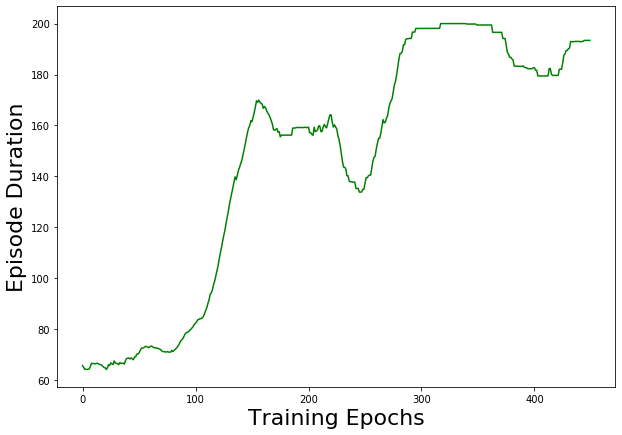

In [15]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

##### Listing 4.9

In [11]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float()) #G
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
        state2, reward, done, info = env.step(action) #I
        state1 = state2 
        t += 1
        if t > MAX_DUR: #L
            break;
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

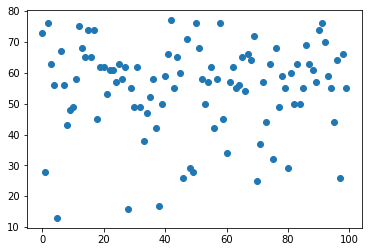

In [12]:
plt.scatter(np.arange(score.shape[0]),score)